<a href="https://colab.research.google.com/github/Saharsh2k5/ML_ASSIGNMENT_2/blob/main/Task_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Task 5 : Image Compression using Matrix Factorisation

You have an image patch of size (50x50) that you want to compress using matrix factorization. To do this, you'll split the patch
[
N
×
N
]
 into two smaller matrices of size
[
N
×
r
]
 and
[
r
×
N
]
 using matrix factorization. Compute the compressed patch by multiplying these two matrices and compare the reconstructed image patch with the original patch. Compute the Root Mean Squared Error (RMSE) and Peak Signal-to-Noise Ratio (PSNR) between the original and reconstructed image patches.

Test different values for the low-rank
r
=
[
5
,
10
,
25
,
50
]
.
Use Gradient Descent to learn the compressed matrices.
Display the reconstructed image patches, keeping the original pixel values outside the patch unchanged, and use your compressed matrix for the patch to show how well the reconstruction works.
Compute the RMSE and PSNR for each value of
r
.
Here is a reference set of patches that you can choose. You can chose an image of your liking and create patches. You can choose the image shown below as well.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

import torch
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

In [ ]:
# Image completion
import os
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

--2024-09-18 17:28:35--  https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg
Resolving segment-anything.com (segment-anything.com)... 3.165.102.25, 3.165.102.29, 3.165.102.75, ...
Connecting to segment-anything.com (segment-anything.com)|3.165.102.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 221810 (217K) [image/jpeg]
Saving to: ‘dog.jpg’

dog.jpg             100%[===================>] 216.61K  --.-KB/s    in 0.006s  

2024-09-18 17:28:36 (35.2 MB/s) - ‘dog.jpg’ saved [221810/221810]



In [ ]:
# Read in a image from torchvision
import torchvision
img = torchvision.io.read_image("dog.jpg")
print(img.shape)

torch.Size([3, 1365, 2048])


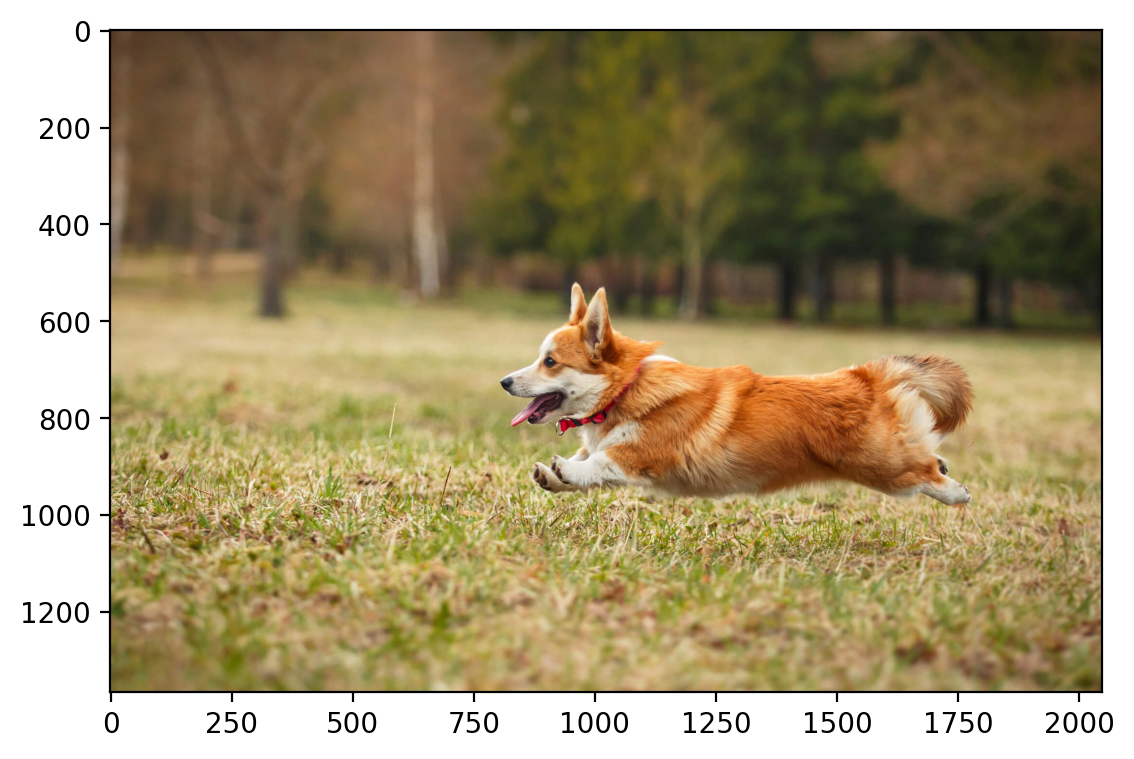

In [ ]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

In [ ]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img

MinMaxScaler()

In [ ]:
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)


img_scaled = torch.tensor(img_scaled)
img_scaled.shape

torch.Size([3, 1365, 2048])

In [ ]:
img_scaled = img_scaled.to(device)
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 600, 800, 300, 300)
crop.shape

torch.Size([3, 300, 300])

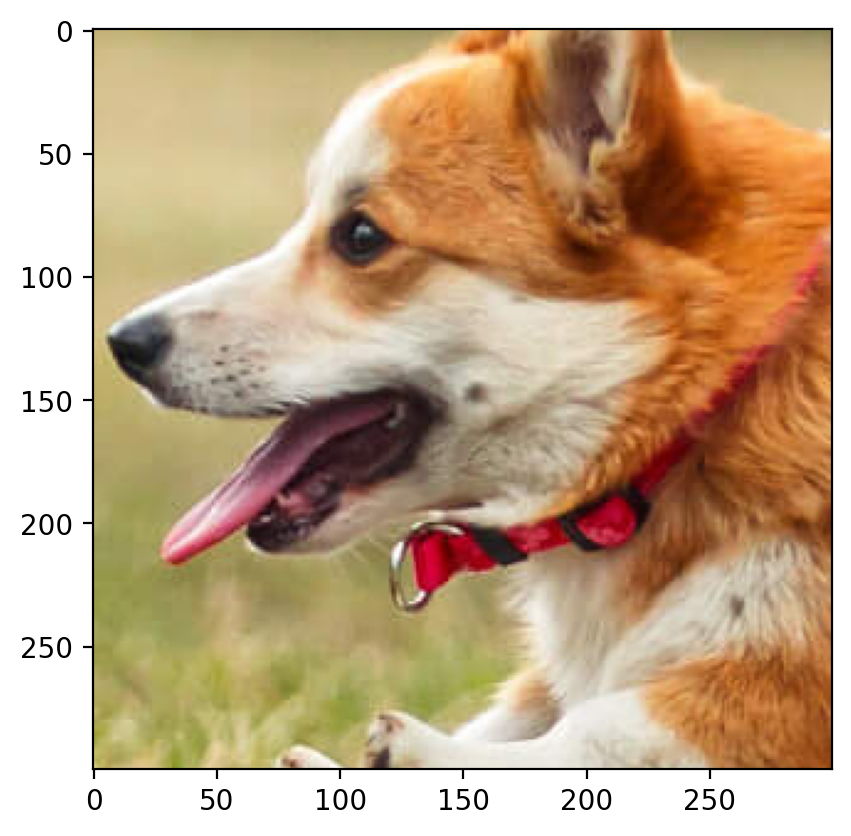

In [ ]:
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())


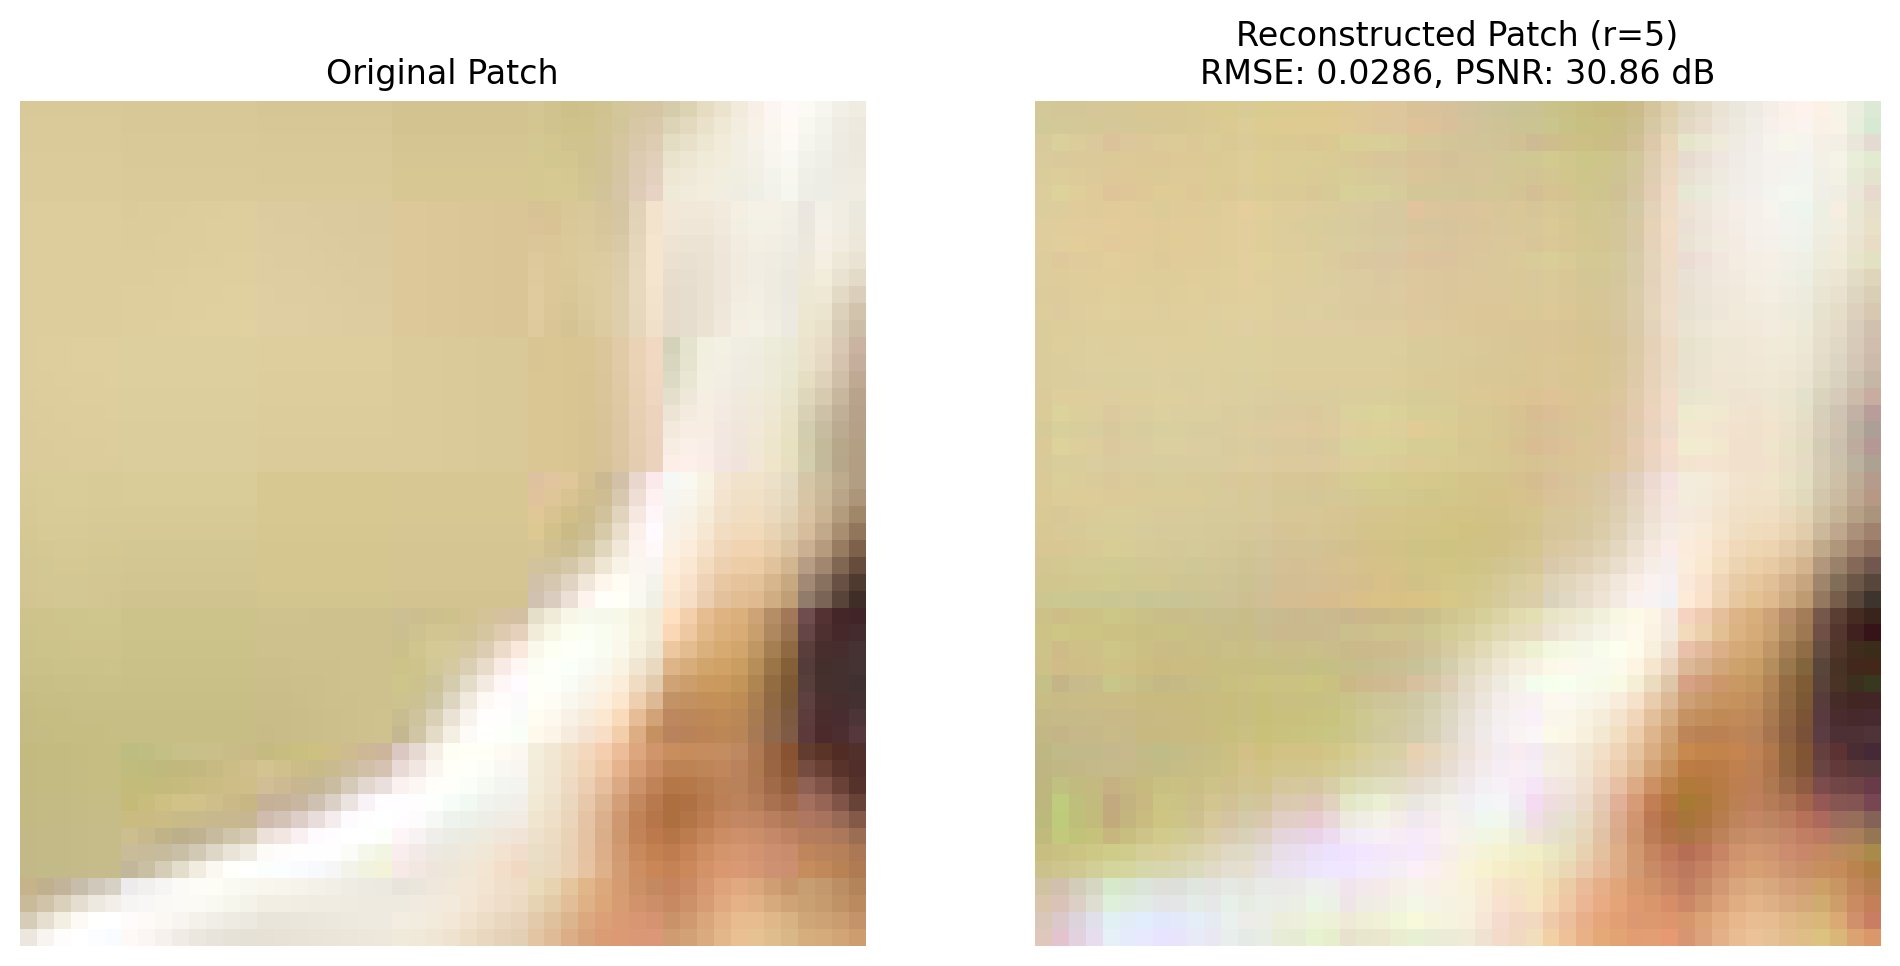

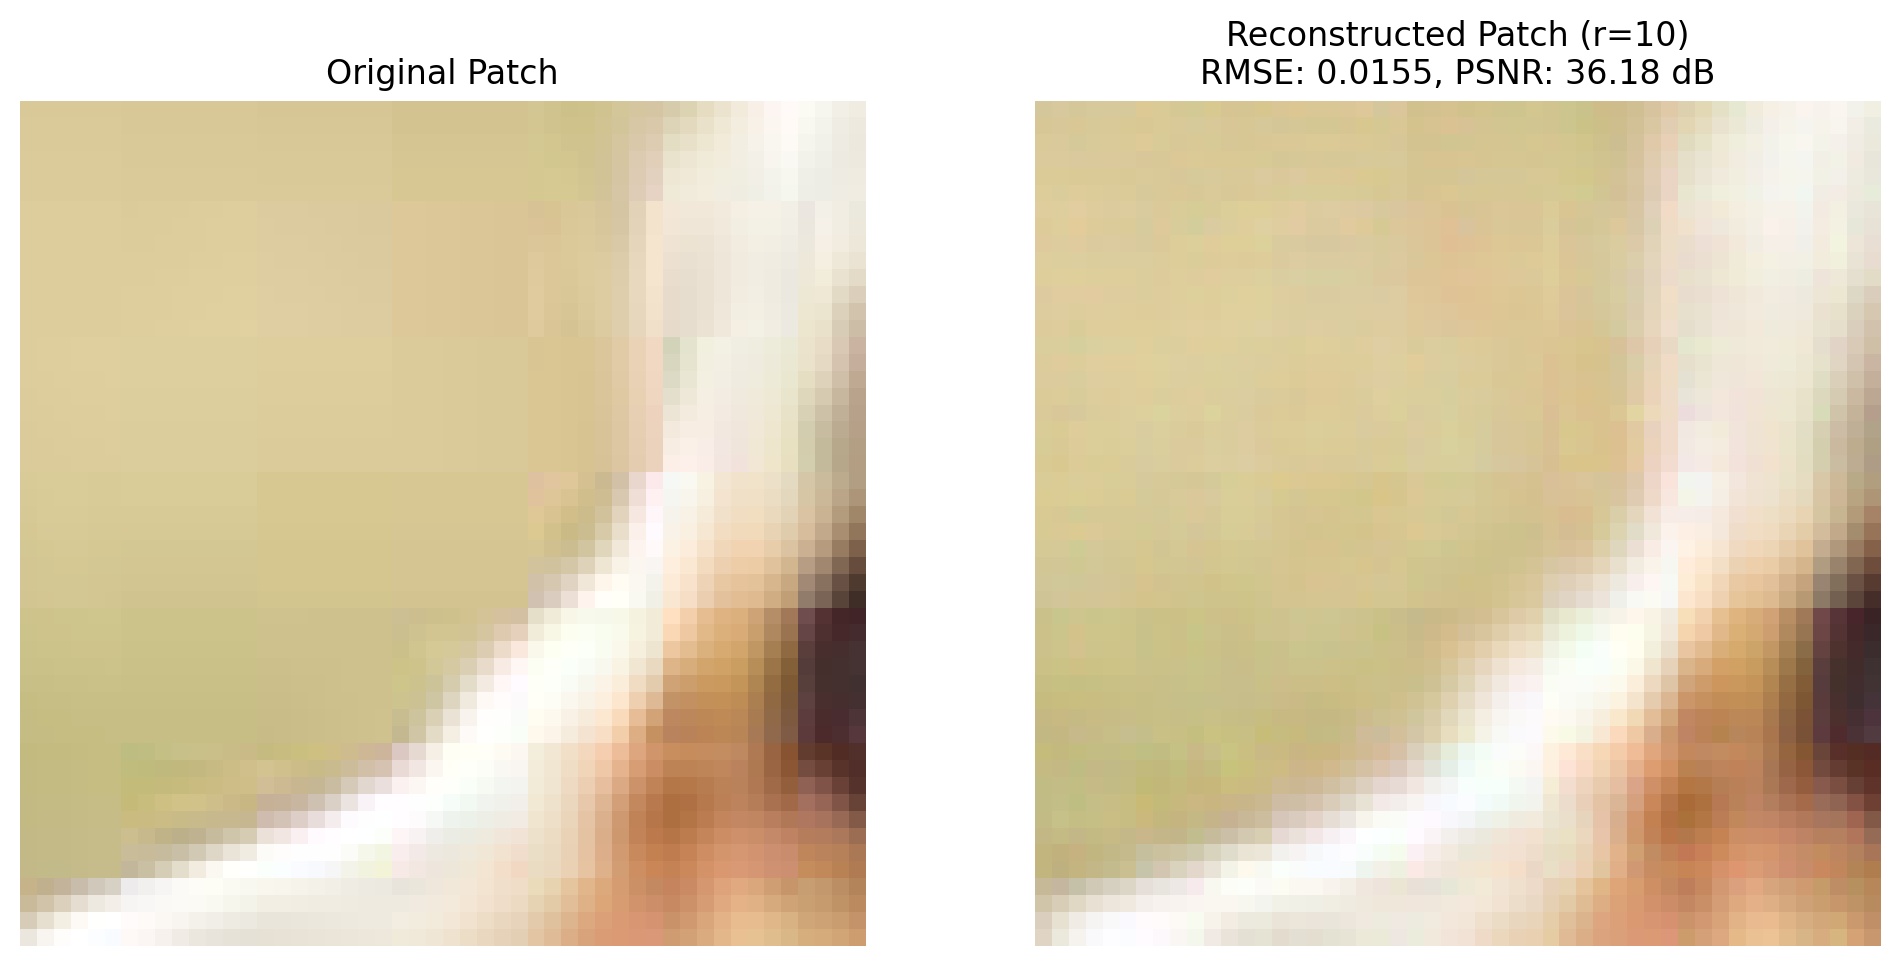

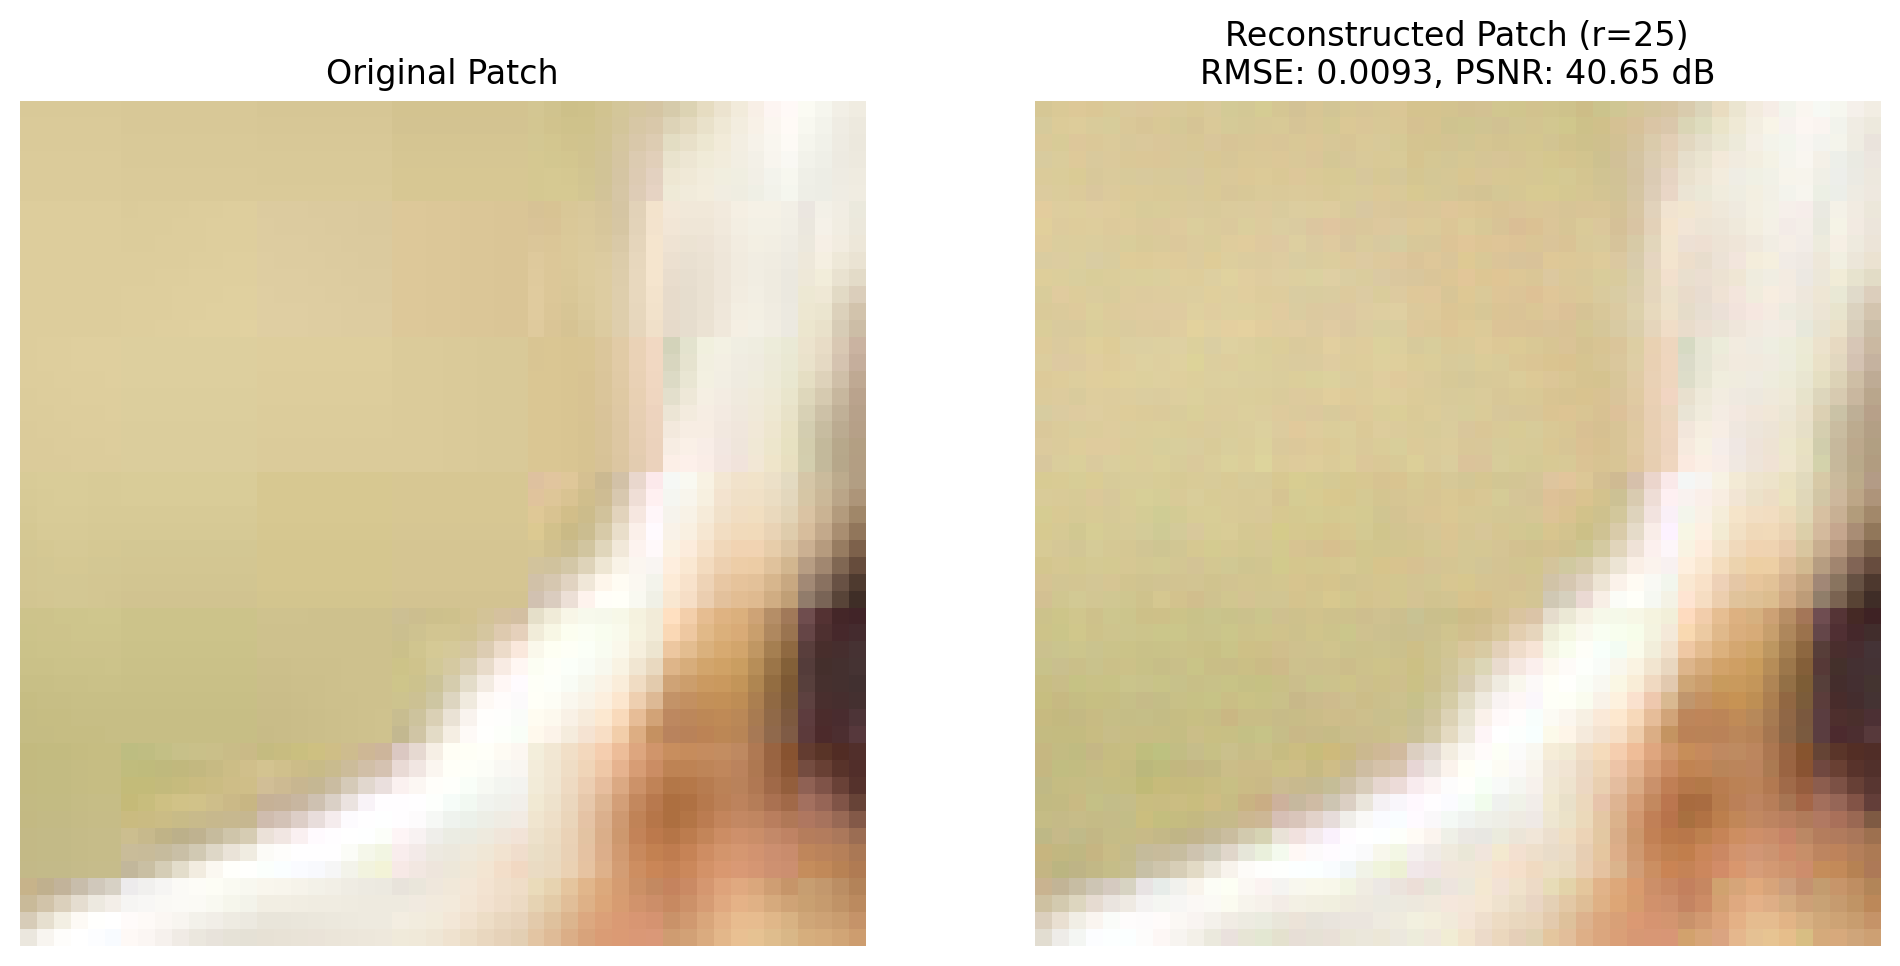

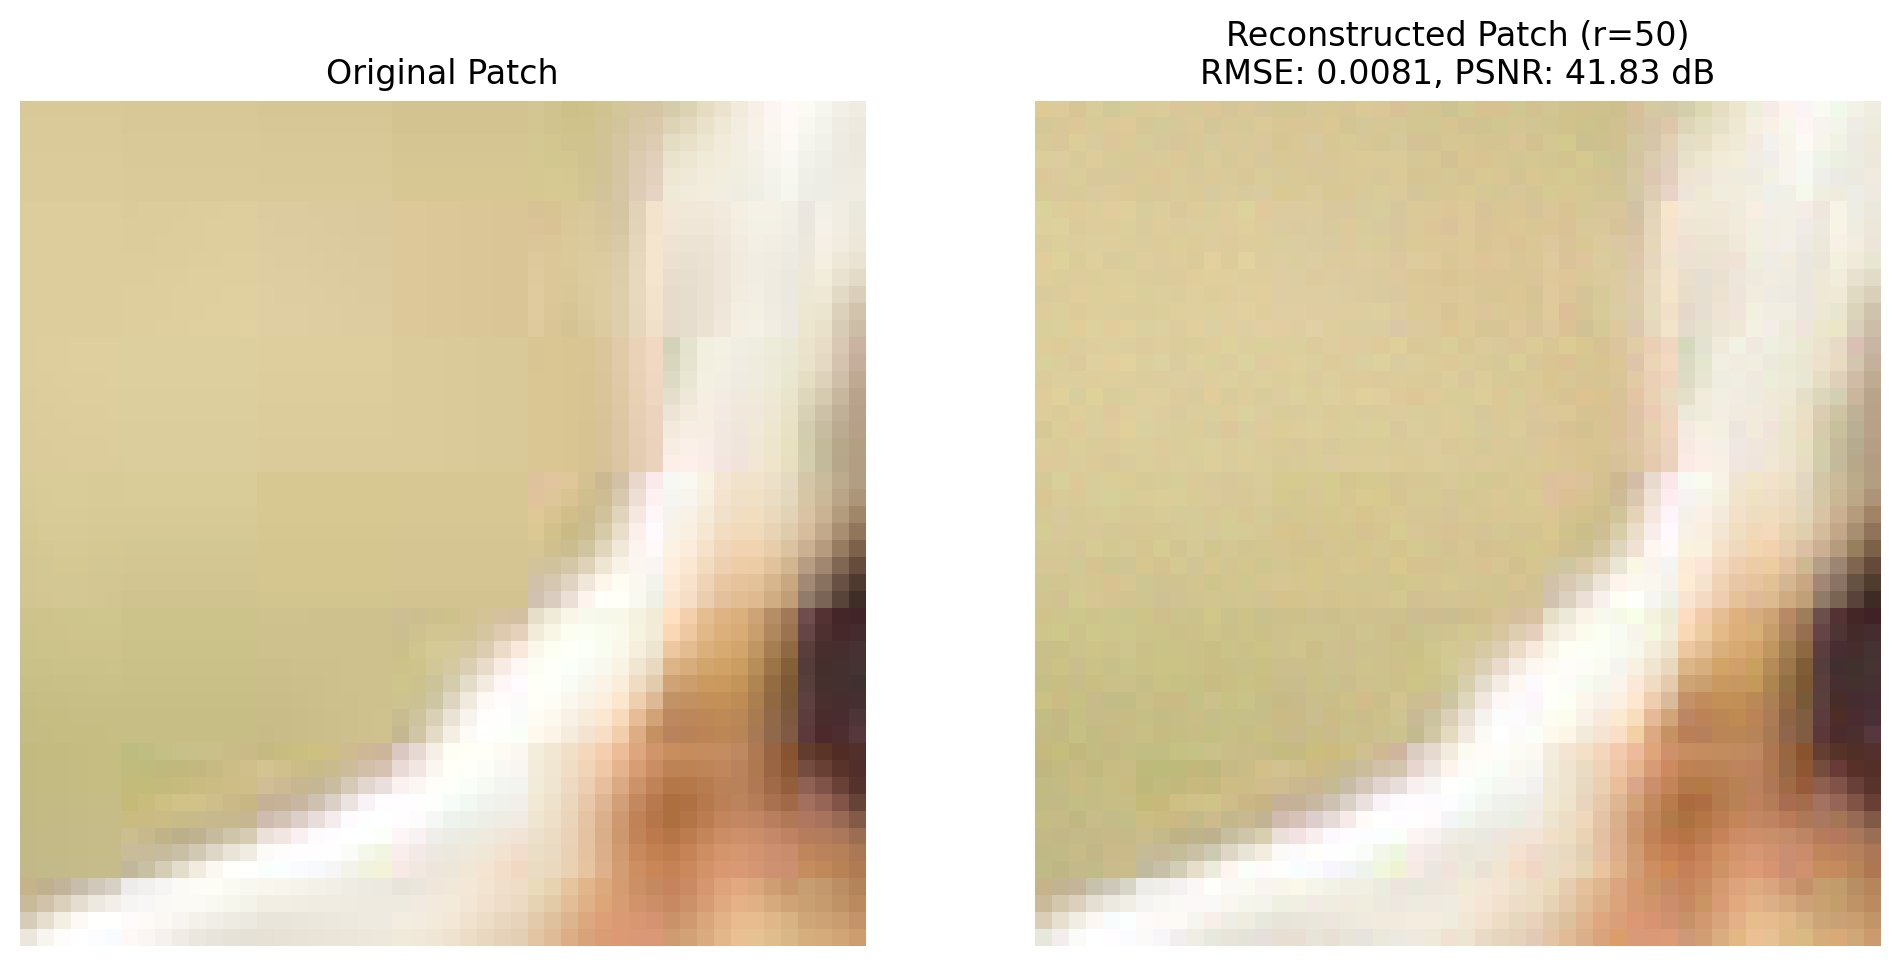

In [ ]:
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 600, 800, 300, 300)

# Remove the batch dimension
patch_size = 50
top, left = 50, 50
crop = torchvision.transforms.functional.crop(crop, top, left, patch_size, patch_size).squeeze(0)

# Function to factorize and reconstruct the patch using Gradient Descent
def factorize_patch(A, r, iterations=2000, lr=0.01):
    N = A.shape[0]  # Patch size
    A = A.view(N, N).to(torch.device("cpu"))
    W = torch.randn(N, r, requires_grad=True, device='cpu')
    H = torch.randn(r, N, requires_grad=True, device='cpu')
    optimizer = torch.optim.Adam([W, H], lr=lr)

    for _ in range(iterations):
        optimizer.zero_grad()
        loss = torch.norm(torch.mm(W, H) - A)
        loss.backward()
        optimizer.step()

    return W, H

# Function to compute RMSE and PSNR
def compute_rmse_psnr(original, reconstructed):
    mse = torch.mean((original - reconstructed) ** 2)
    rmse = torch.sqrt(mse).item()
    psnr = 20 * torch.log10(1.0 / torch.sqrt(mse)).item()  # assuming pixel values are normalized between 0 and 1
    return rmse, psnr

# Test different values of r and display results
r_values = [5, 10, 25, 50]

for r in r_values:
    # Convert each channel to grayscale for simplicity
    reconstructed_patch = torch.zeros_like(crop)

    for c in range(crop.shape[0]):  # Iterate over each color channel
        channel_patch = crop[c]  # Extract the channel
        gray_patch = channel_patch.view(crop.shape[1], crop.shape[2])

        # Factorize the patch
        W, H = factorize_patch(gray_patch, r)

        # Reconstruct the patch
        reconstructed_channel = torch.mm(W, H).detach()
        reconstructed_patch[c] = reconstructed_channel

    # Compute RMSE and PSNR for each channel
    rmse, psnr = compute_rmse_psnr(crop, reconstructed_patch)

    # Display the original and reconstructed patches
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(crop.permute(1, 2, 0).cpu())
    plt.title("Original Patch")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed_patch.permute(1, 2, 0).cpu())
    plt.title(f"Reconstructed Patch (r={r})\nRMSE: {rmse:.4f}, PSNR: {psnr:.2f} dB")
    plt.axis("off")

    plt.show()


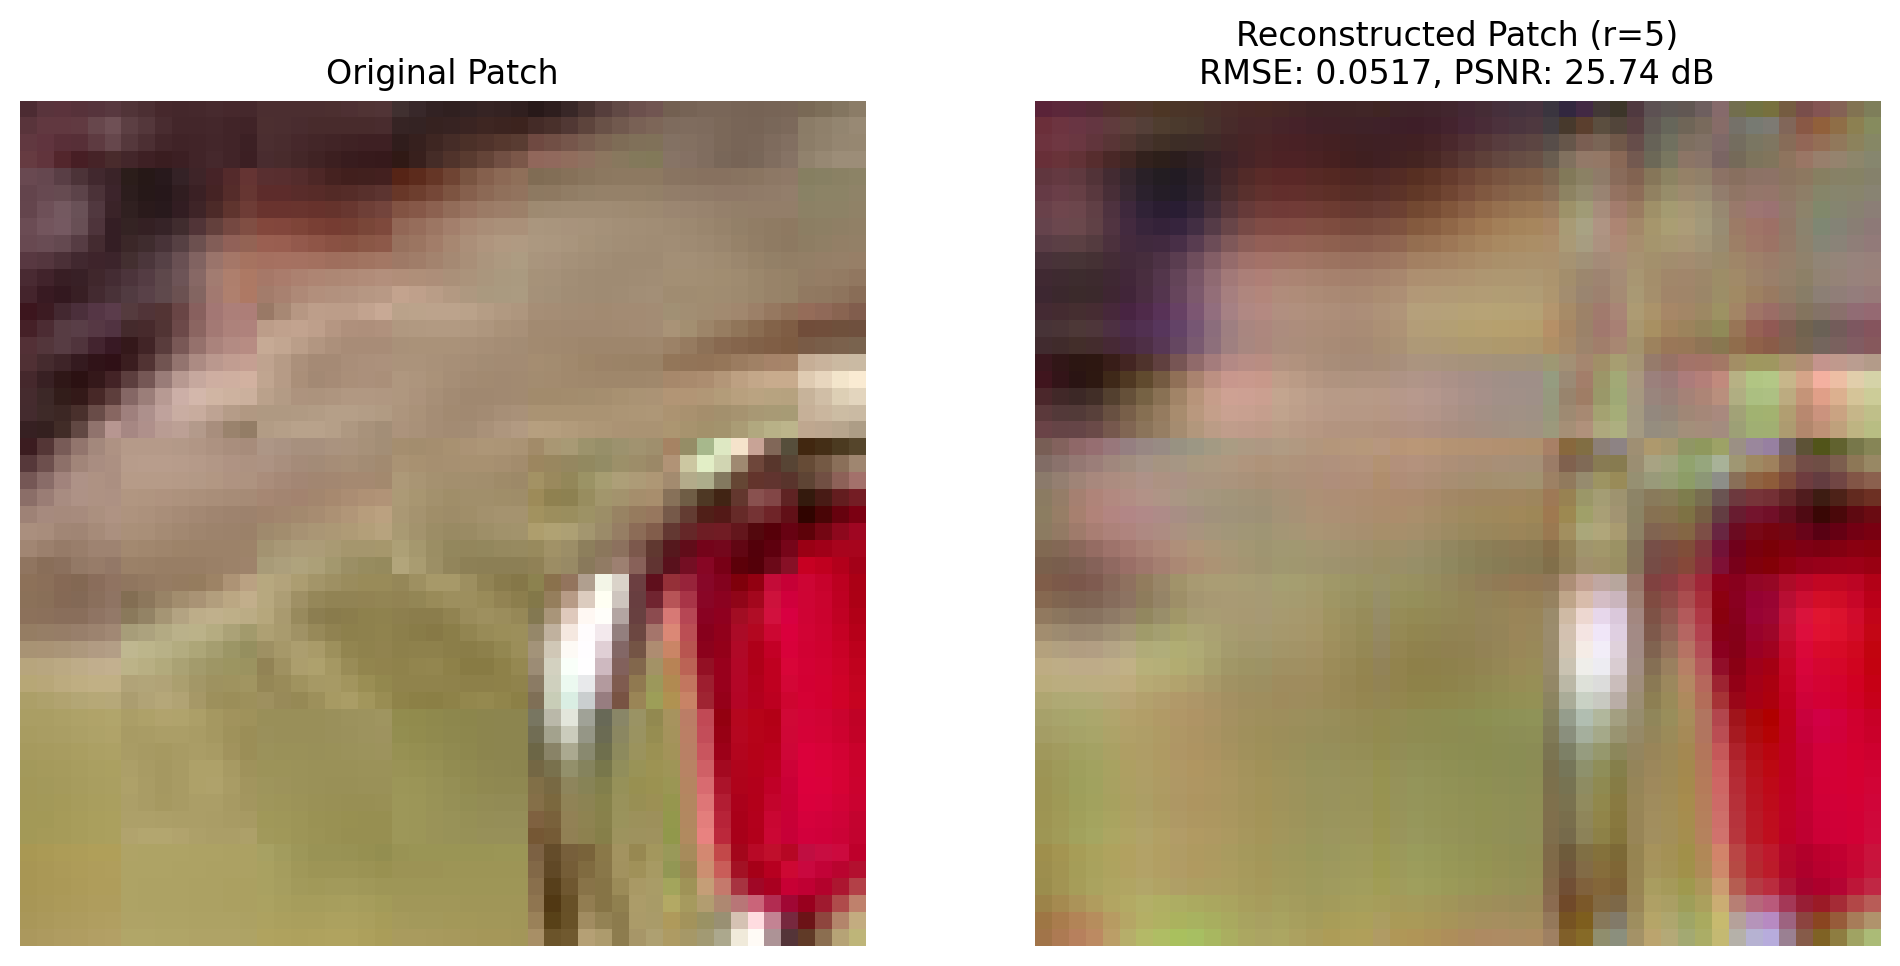

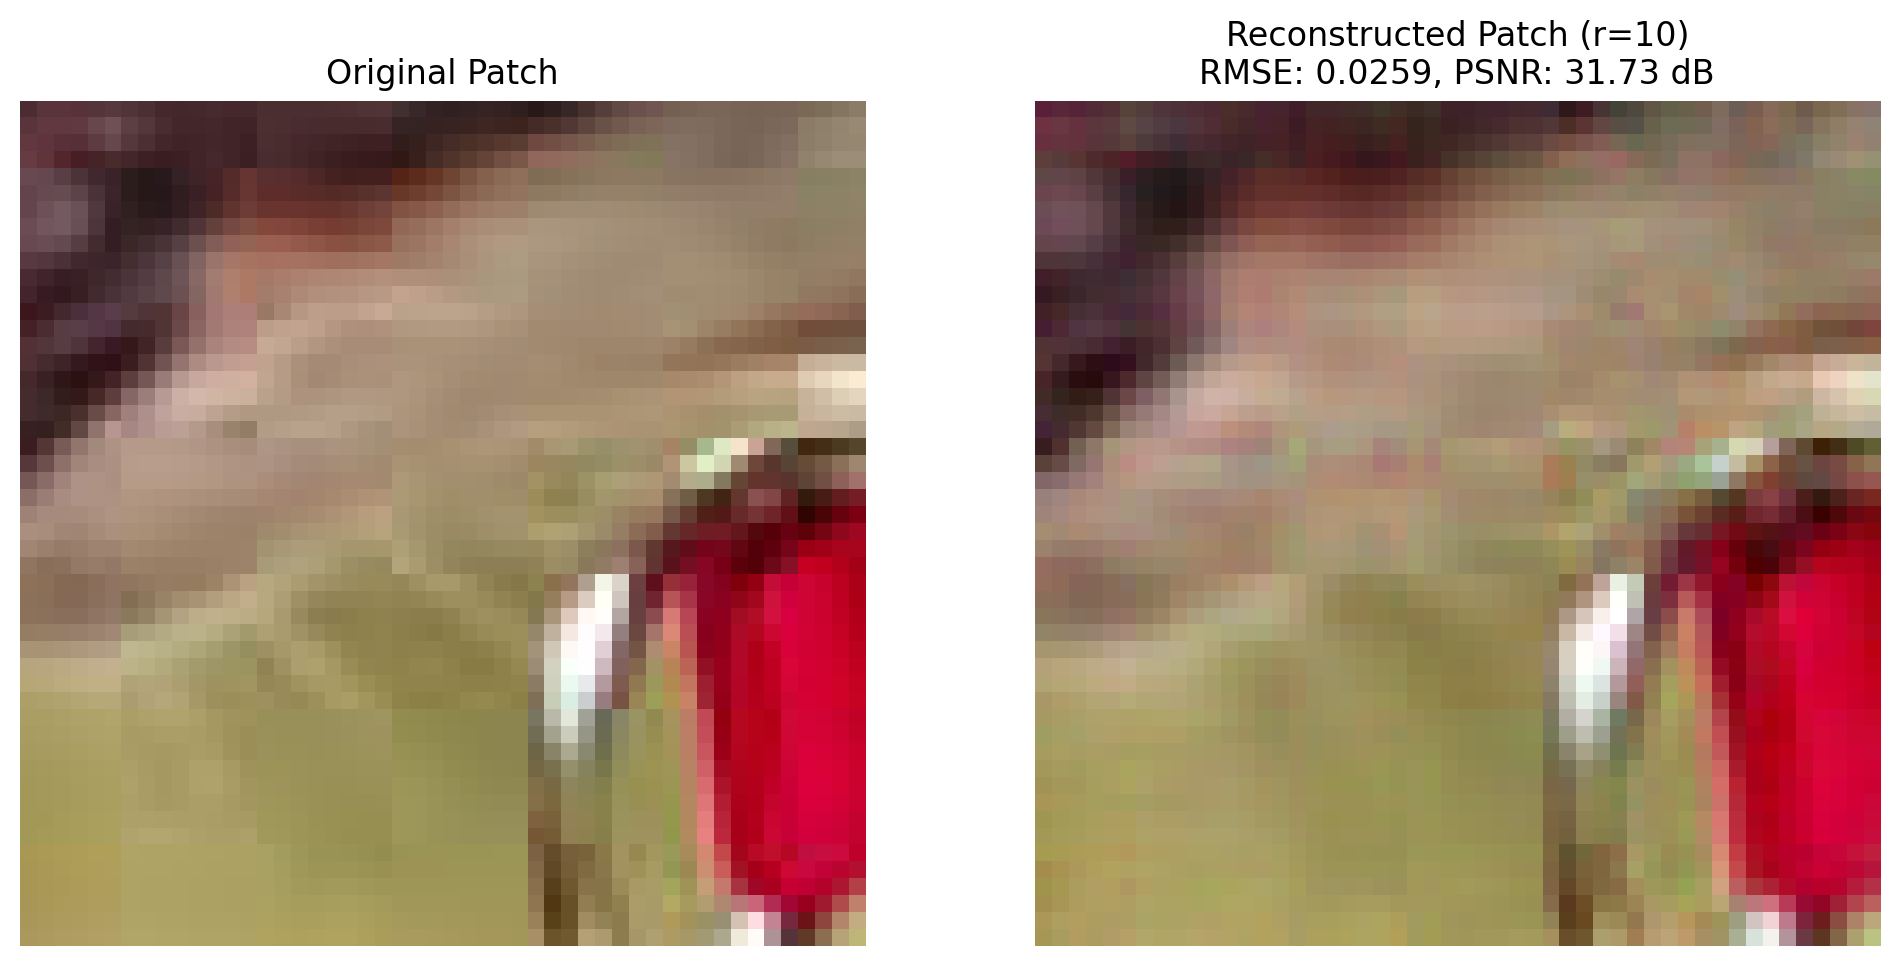

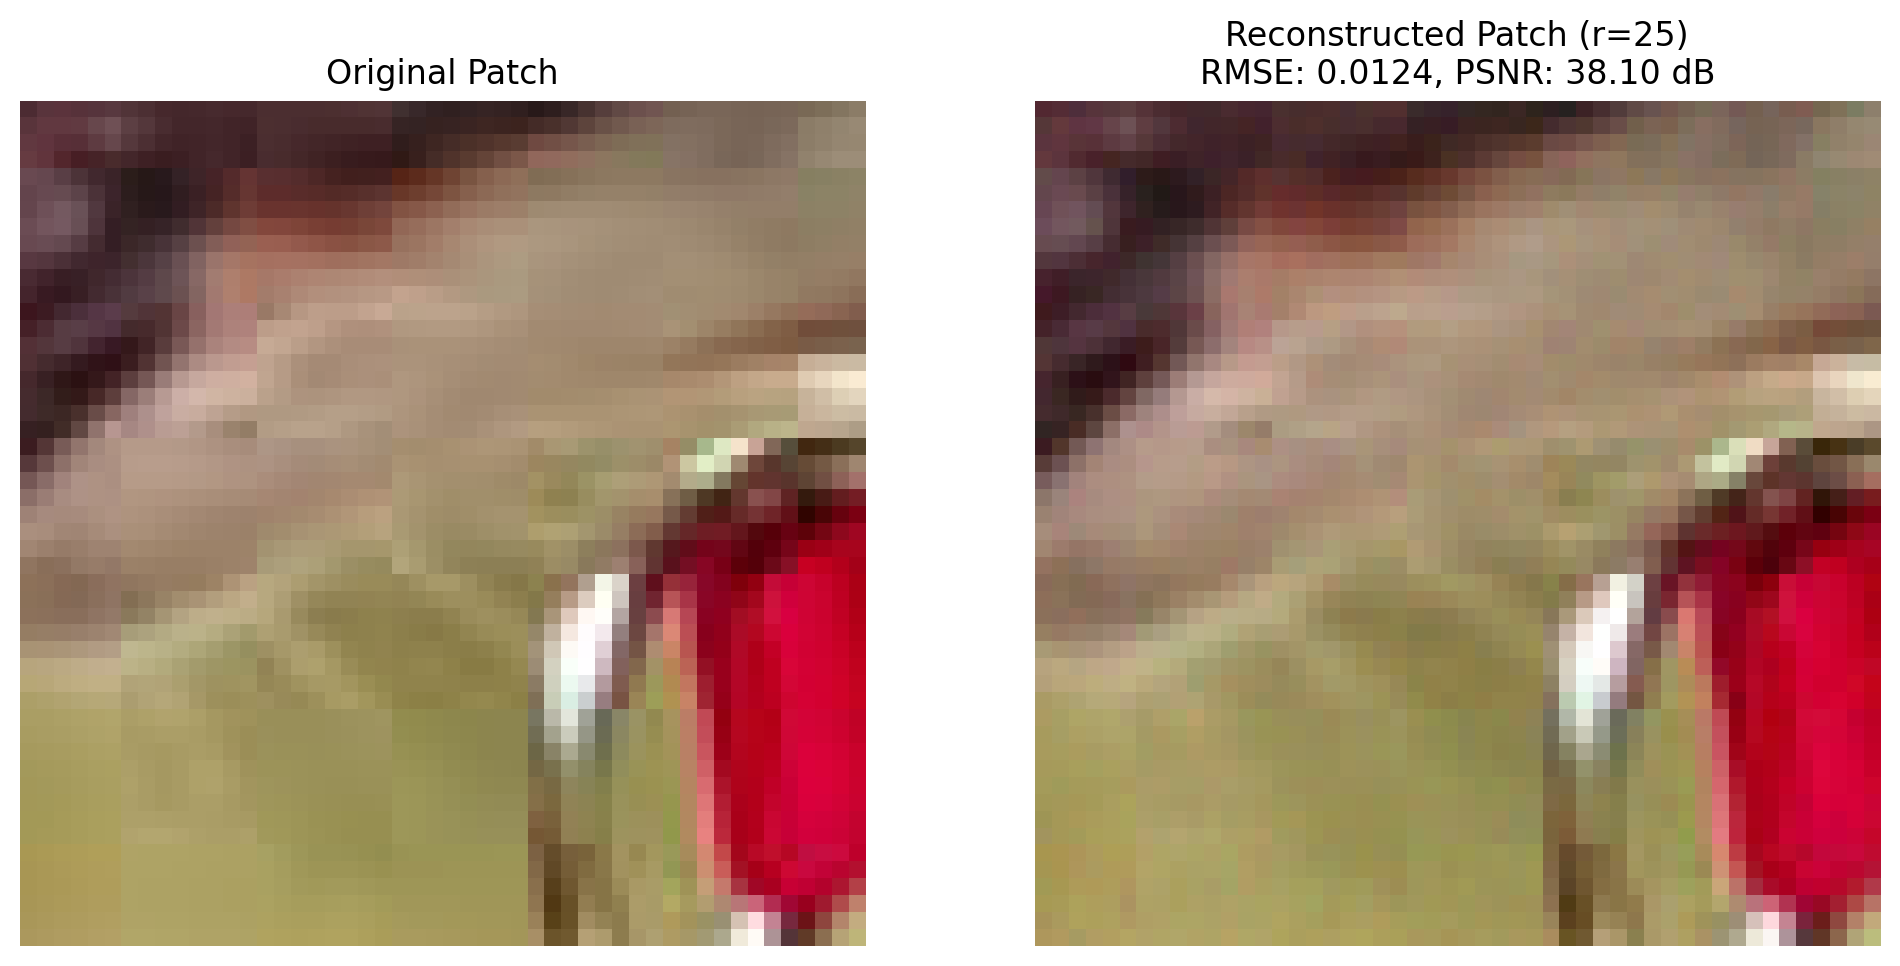

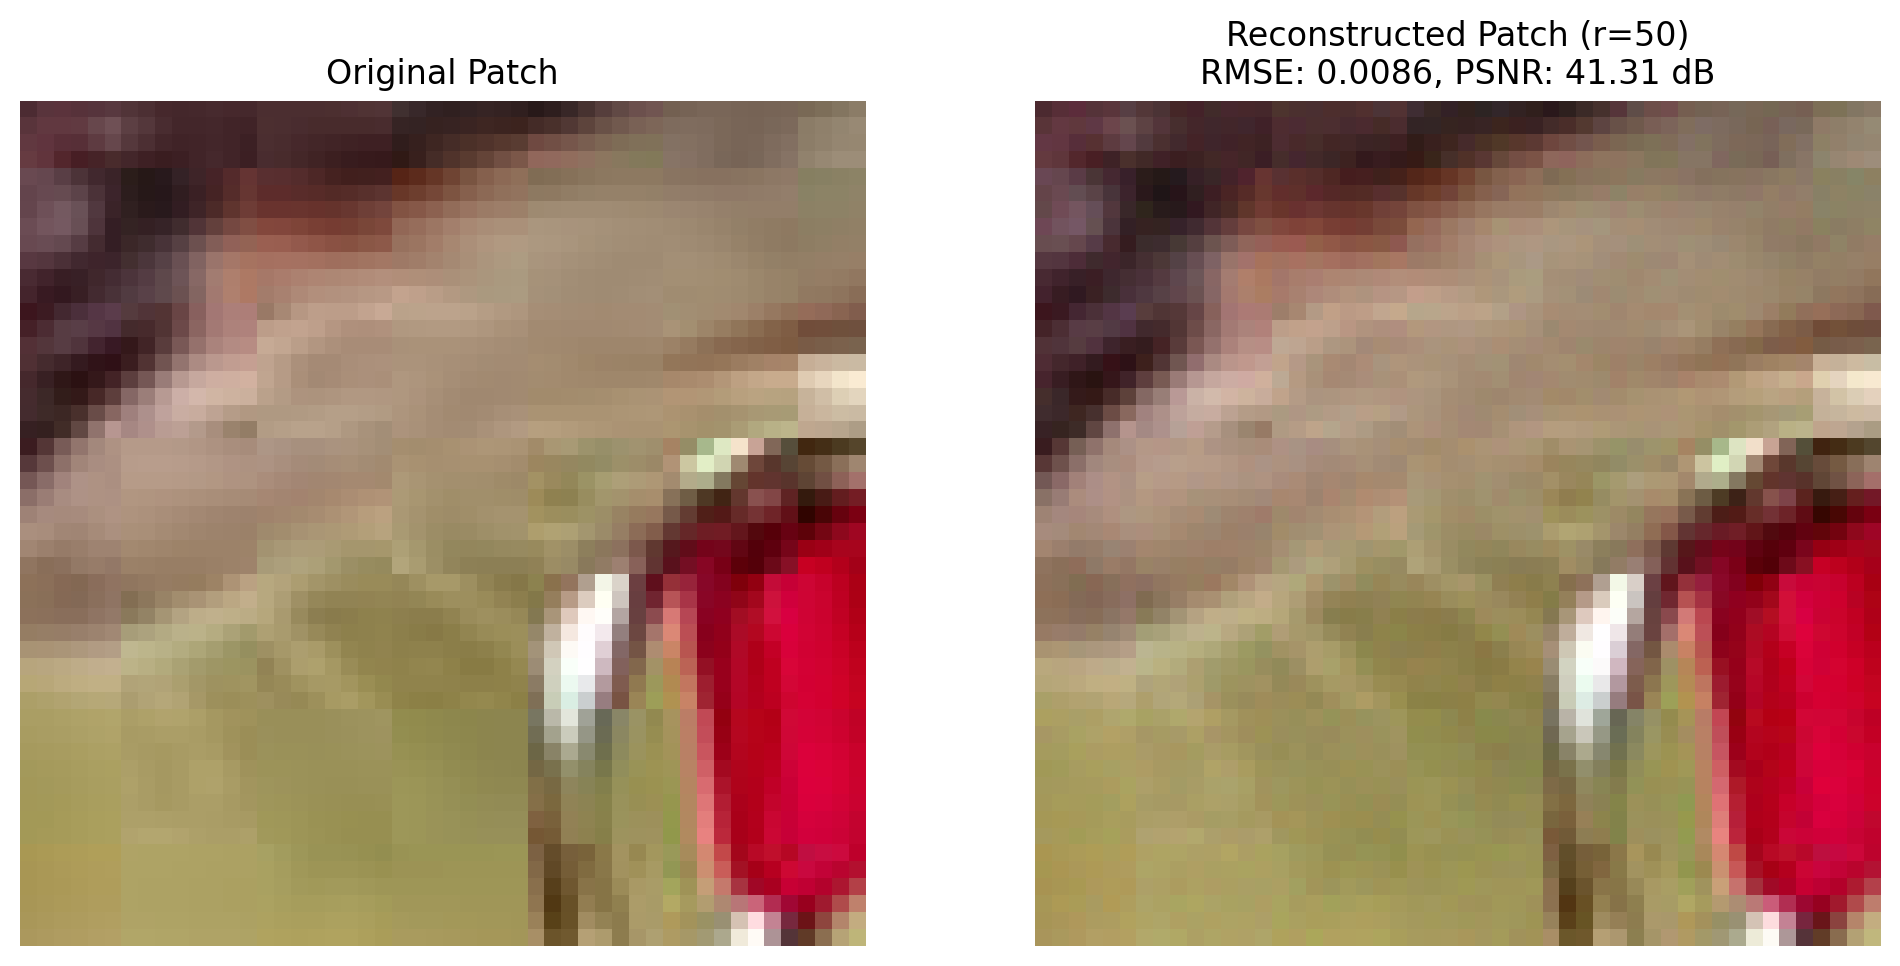

In [ ]:

# Extract a 300x300 patch from the image
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 600, 800, 300, 300)

# Remove the batch dimension
patch_size = 50
top, left = 180, 90
crop = torchvision.transforms.functional.crop(crop, top, left, patch_size, patch_size).squeeze(0)  # Shape: [C, H, W]

# Function to factorize and reconstruct the patch using Adam optimizer
def factorize_patch(A, r, iterations=2000, lr=0.01):
    N = A.shape[0]  # Patch size
    A = A.view(N, N).to(torch.device("cpu"))
    W = torch.randn(N, r, requires_grad=True, device='cpu')
    H = torch.randn(r, N, requires_grad=True, device='cpu')
    optimizer = torch.optim.Adam([W, H], lr=lr)

    for _ in range(iterations):
        optimizer.zero_grad()
        loss = torch.norm(torch.mm(W, H) - A)
        loss.backward()
        optimizer.step()

    return W, H

# Function to compute RMSE and PSNR
def compute_rmse_psnr(original, reconstructed):
    mse = torch.mean((original - reconstructed) ** 2)
    rmse = torch.sqrt(mse).item()
    psnr = 20 * torch.log10(1.0 / torch.sqrt(mse)).item()  # assuming pixel values are normalized between 0 and 1
    return rmse, psnr

# Test different values of r and display results
r_values = [5, 10, 25, 50]

for r in r_values:
    # Convert each channel to grayscale for simplicity
    reconstructed_patch = torch.zeros_like(crop)

    for c in range(crop.shape[0]):  # Iterate over each color channel
        channel_patch = crop[c]  # Extract the channel
        gray_patch = channel_patch.view(crop.shape[1], crop.shape[2])

        # Factorize the patch
        W, H = factorize_patch(gray_patch, r)

        # Reconstruct the patch
        reconstructed_channel = torch.mm(W, H).detach()
        reconstructed_patch[c] = reconstructed_channel

    # Compute RMSE and PSNR for the reconstructed patch
    rmse, psnr = compute_rmse_psnr(crop, reconstructed_patch)

    # Display the original and reconstructed patches
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(crop.permute(1, 2, 0).cpu())
    plt.title("Original Patch")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed_patch.permute(1, 2, 0).cpu())
    plt.title(f"Reconstructed Patch (r={r})\nRMSE: {rmse:.4f}, PSNR: {psnr:.2f} dB")
    plt.axis("off")

    plt.show()


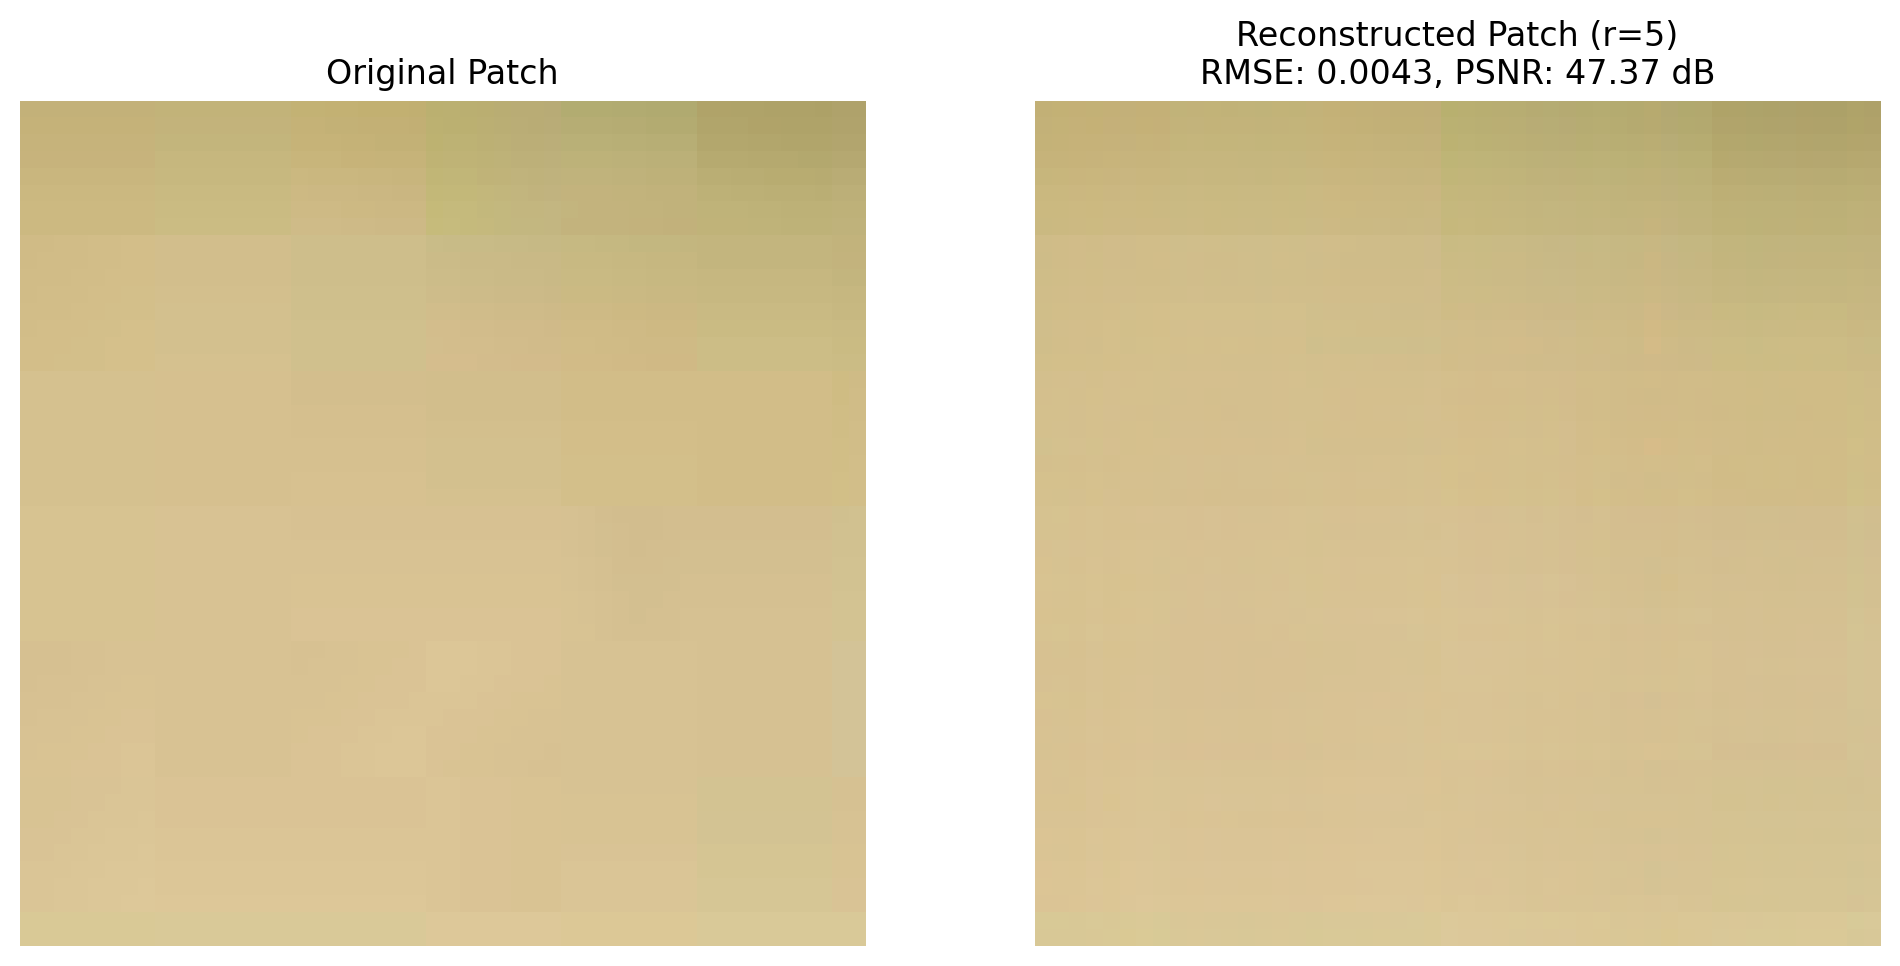

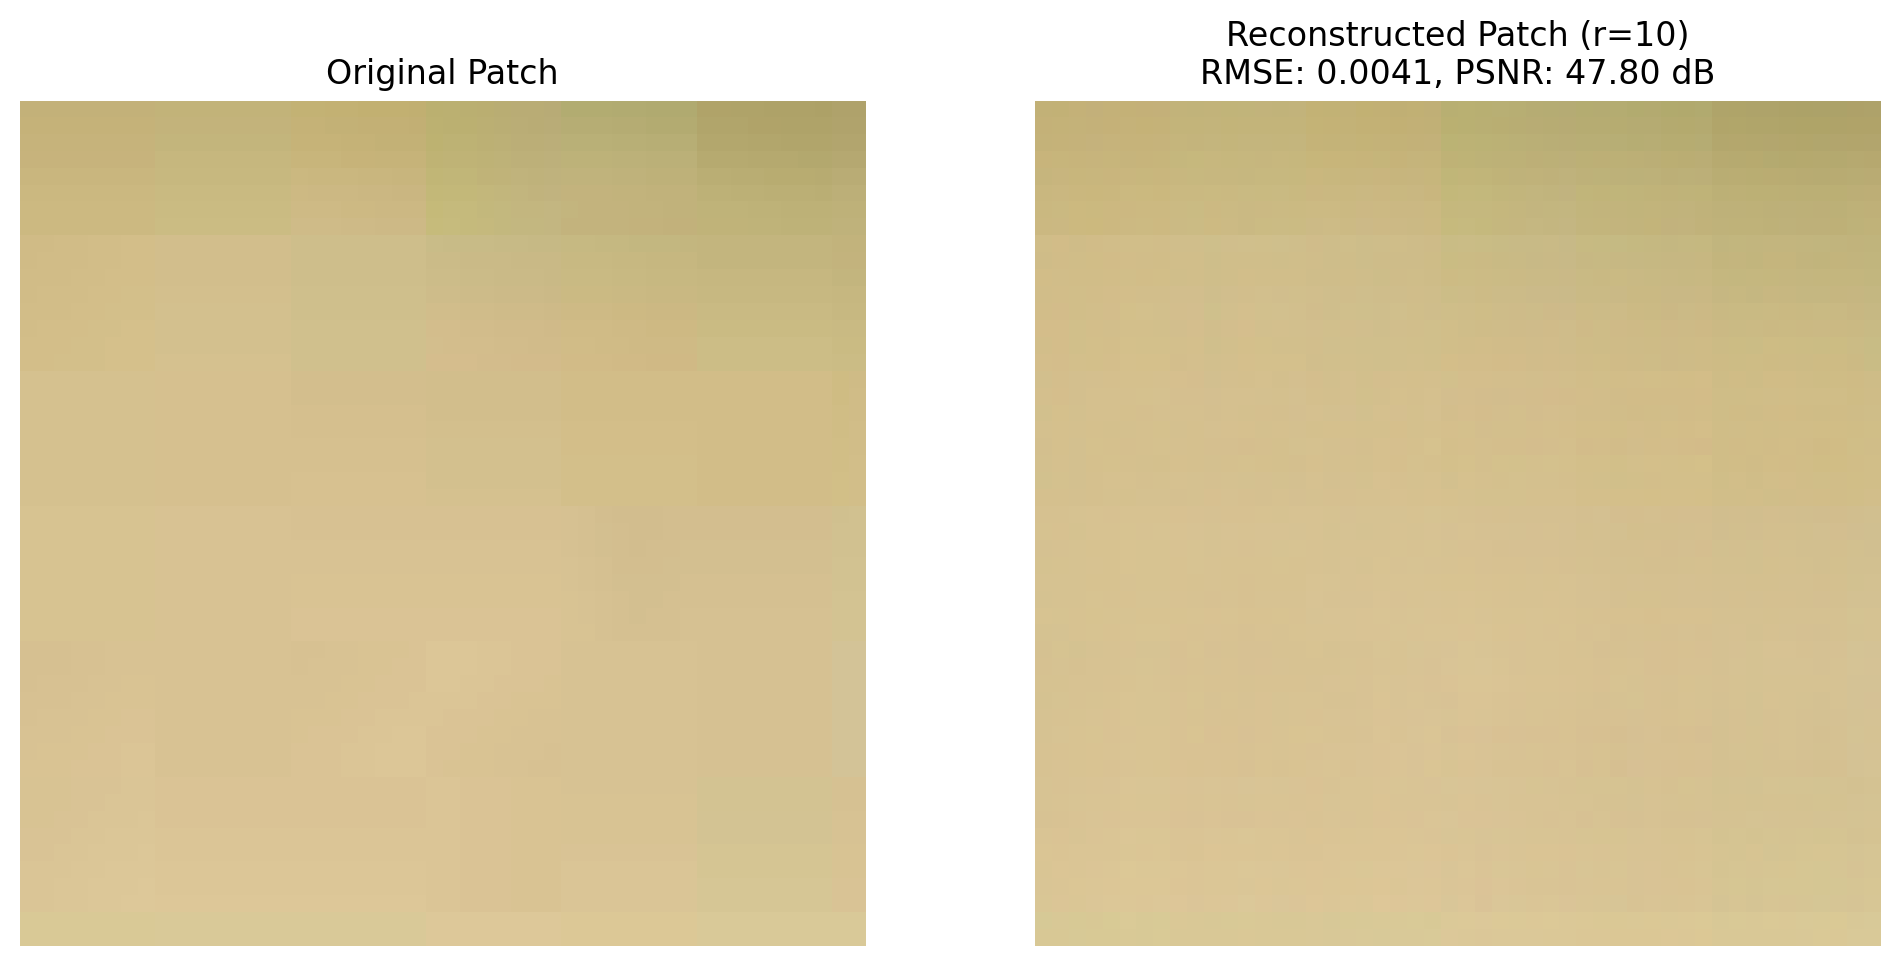

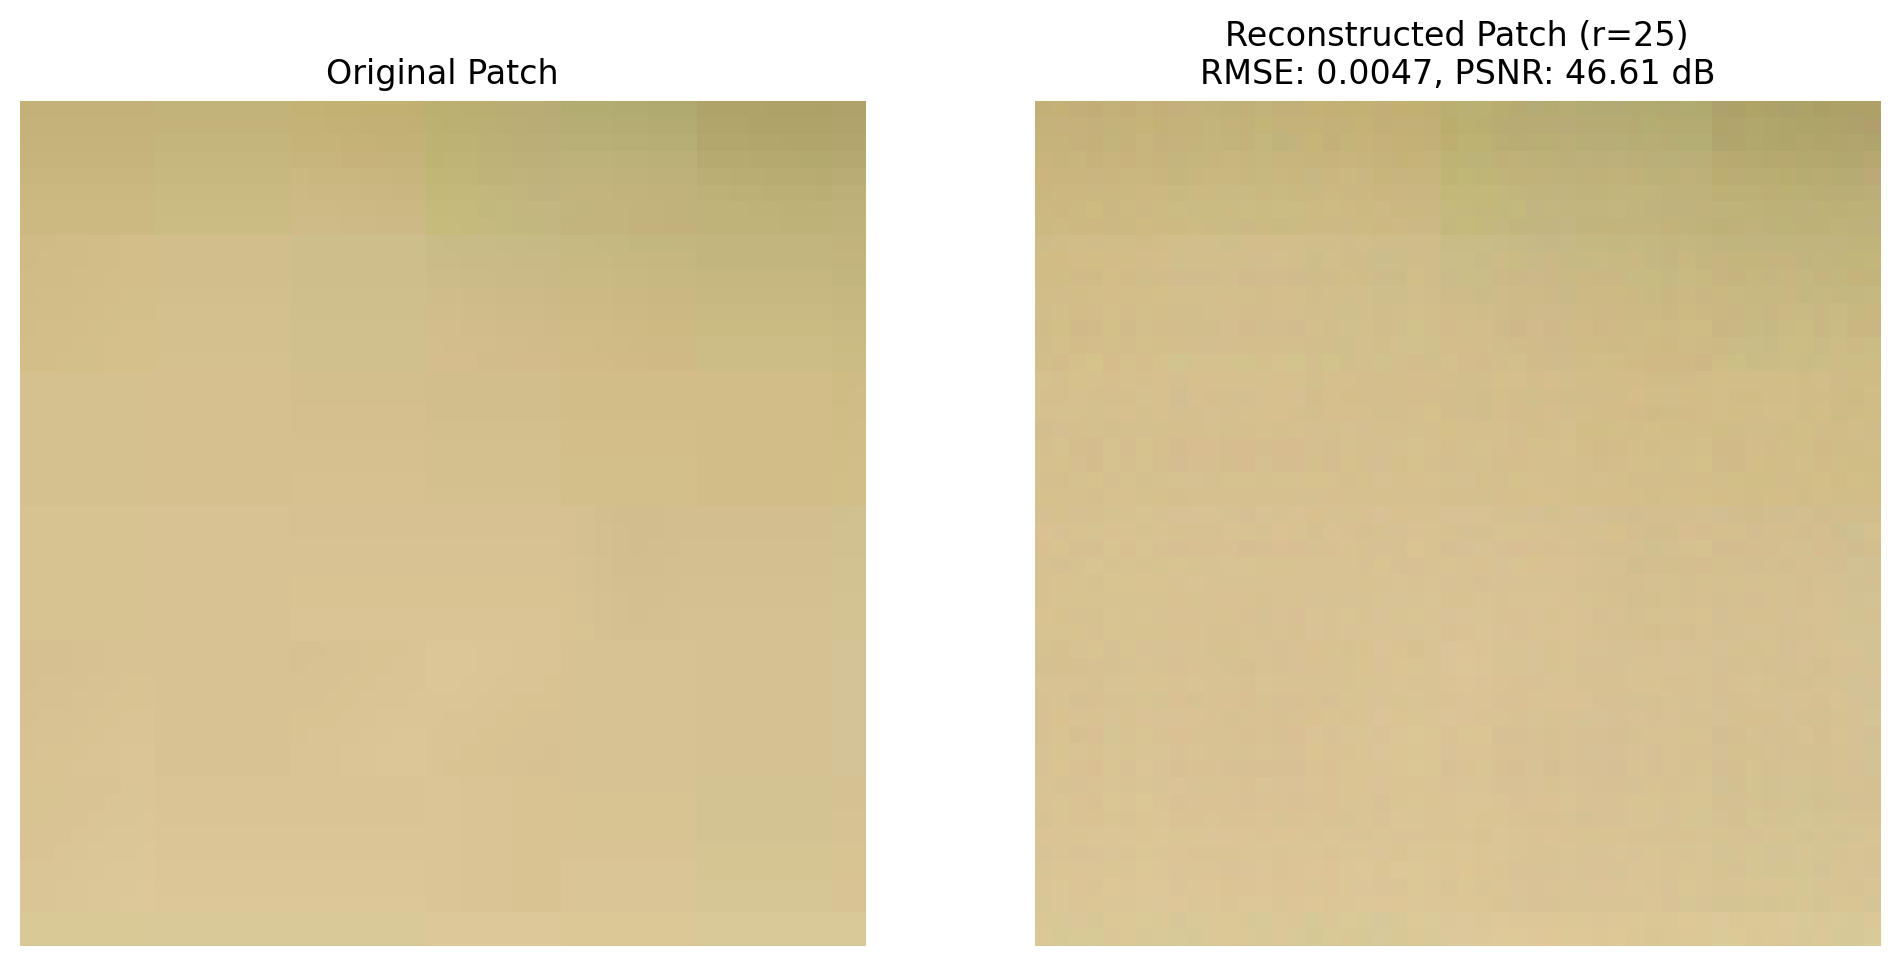

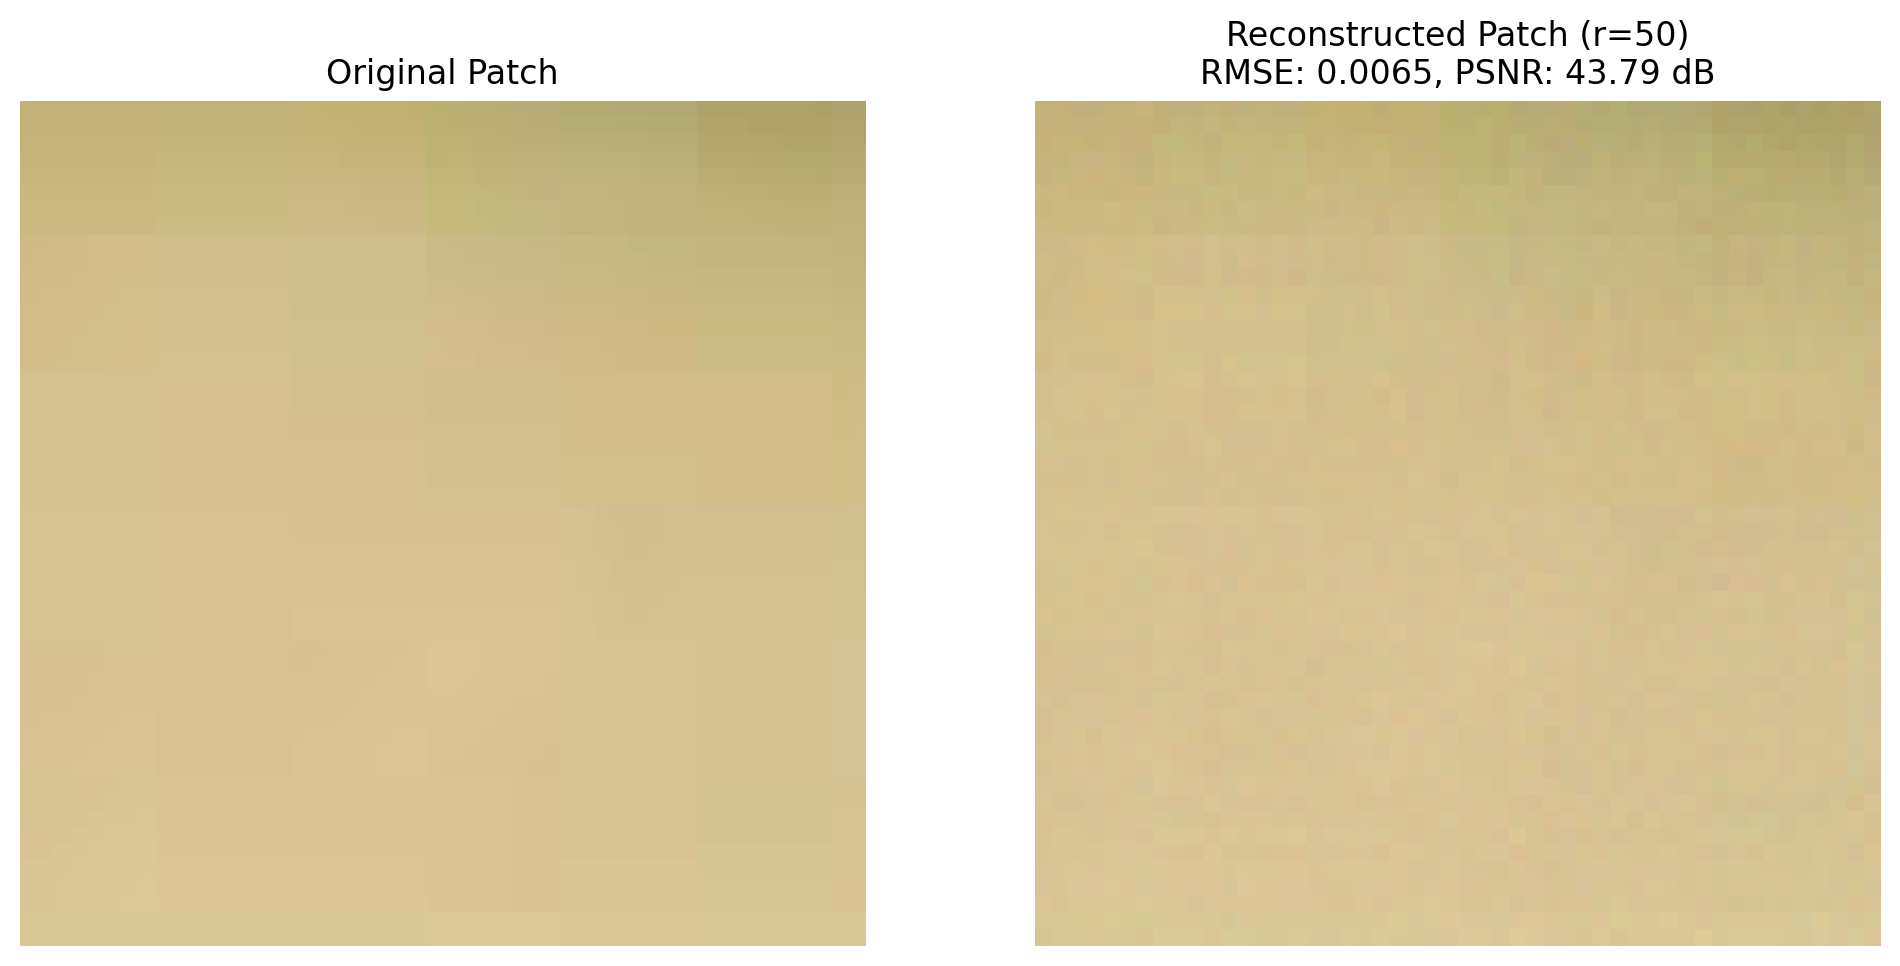

In [ ]:
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 600, 800, 300, 300)
patch_size = 50
top, left =  0,0
crop = torchvision.transforms.functional.crop(crop, top, left, patch_size, patch_size).squeeze(0)
for r in r_values:
    # Convert each channel to grayscale for simplicity
    reconstructed_patch = torch.zeros_like(crop)

    for c in range(crop.shape[0]):  # Iterate over each color channel
        channel_patch = crop[c]  # Extract the channel
        gray_patch = channel_patch.view(crop.shape[1], crop.shape[2])

        # Factorize the patch
        W, H = factorize_patch(gray_patch, r)

        # Reconstruct the patch
        reconstructed_channel = torch.mm(W, H).detach()
        reconstructed_patch[c] = reconstructed_channel

    # Compute RMSE and PSNR for each channel
    rmse, psnr = compute_rmse_psnr(crop, reconstructed_patch)

    # Display the original and reconstructed patches
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(crop.permute(1, 2, 0).cpu())
    plt.title("Original Patch")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed_patch.permute(1, 2, 0).cpu())
    plt.title(f"Reconstructed Patch (r={r})\nRMSE: {rmse:.4f}, PSNR: {psnr:.2f} dB")
    plt.axis("off")

    plt.show()